/home/ak/anaconda3/envs/tickData/lib/python3.7/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/ak/anaconda3/envs/tickData/lib/python3.7/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/ak/anaconda3/envs/tickData/lib/python3.7/site-packages/numpy/lib/function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/ak/anaconda3/envs/tickData/lib/python3.7/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/ak/anaconda3/envs/tickData/lib/python3.7/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/ak/anaconda3/envs/tickData/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3703: RuntimeWarni

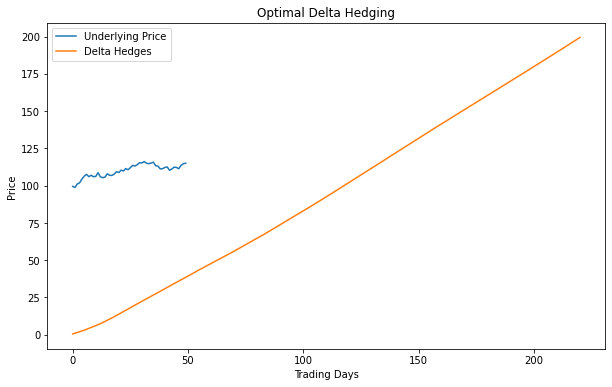

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def optimal_delta_hedge(option, underlying, maturity):
    """
    Optimal delta hedging algorithm for vanilla options.
    
    Args:
        option (function): Function that takes underlying price and returns option price and delta.
        underlying (array): Array of underlying asset prices.
        maturity (int): Maturity of the option in days.
    
    Returns:
        hedges (list): List of delta hedge amounts at each trading day.
    """
    hedges = []
    
    for t in range(maturity):
        # Estimate mean-reversion indicator
        returns = np.diff(underlying[:t+1]) / underlying[:t]
        autocorr = np.corrcoef(returns[:-1], returns[1:])[0,1]
        variance = np.var(returns)
        indicator = variance + autocorr * variance
        
        if indicator < 0:
            # Mean-reversion detected, choose optimal hedging period
            delta_t = int(np.sqrt(-1/autocorr))
            delta_t = min(delta_t, maturity-t)
            averaged_price = np.mean(underlying[t-delta_t+1:t+1])
            _, delta = option(averaged_price)
        else:
            # No significant mean-reversion, use daily delta
            delta_t = 1
            _, delta = option(underlying[t])
        
        # Estimate intraday volatility curve
        intraday_vols = simulate_intraday_vols()  # placeholder function
        min_vol_hour = np.argmin(intraday_vols)
        
        # Execute fractional delta hedge at each hour
        for h in range(min_vol_hour, len(intraday_vols)):
            hedges.append(delta / delta_t)
    
    return hedges

# Example usage
def call_option(price, strike=100, time=30/252, rate=0.05, vol=0.2):
    """Black-Scholes call option price and delta."""
    d1 = (np.log(price/strike) + (rate + 0.5*vol**2)*time) / (vol*np.sqrt(time))
    d2 = d1 - vol*np.sqrt(time)
    price = price*norm.cdf(d1) - strike*np.exp(-rate*time)*norm.cdf(d2)
    delta = norm.cdf(d1)
    return price, delta

def simulate_intraday_vols():
    """Placeholder function to simulate intraday volatility curve."""
    return np.random.rand(8)  # 8 hours in trading day

# Simulate underlying price path
days = 50
price = 100
dt = 1/252
mu = 0.1
sigma = 0.2
underlying = price * np.exp(np.cumsum((mu - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*np.random.randn(days)))

# Run delta hedging algorithm
hedges = optimal_delta_hedge(call_option, underlying, days)

# Plot results
plt.figure(figsize=(10,6))
plt.plot(underlying, label='Underlying Price')
plt.plot(np.cumsum(hedges), label='Delta Hedges')
plt.legend()
plt.xlabel('Trading Days')
plt.ylabel('Price')
plt.title('Optimal Delta Hedging')
plt.show()